In [1]:
!git clone https://github.com/Shenggan/BCCD_Dataset.git
%cd BCCD_Dataset


c:\Users\gurur\OneDrive\Documents\PROJECTS\Hemascope\BCCD_Dataset


Cloning into 'BCCD_Dataset'...
Updating files:  72% (536/743)
Updating files:  73% (543/743)
Updating files:  74% (550/743)
Updating files:  75% (558/743)
Updating files:  76% (565/743)
Updating files:  77% (573/743)
Updating files:  78% (580/743)
Updating files:  79% (587/743)
Updating files:  80% (595/743)
Updating files:  81% (602/743)
Updating files:  82% (610/743)
Updating files:  83% (617/743)
Updating files:  84% (625/743)
Updating files:  85% (632/743)
Updating files:  86% (639/743)
Updating files:  87% (647/743)
Updating files:  88% (654/743)
Updating files:  89% (662/743)
Updating files:  90% (669/743)
Updating files:  91% (677/743)
Updating files:  92% (684/743)
Updating files:  93% (691/743)
Updating files:  94% (699/743)
Updating files:  95% (706/743)
Updating files:  96% (714/743)
Updating files:  97% (721/743)
Updating files:  98% (729/743)
Updating files:  99% (736/743)
Updating files: 100% (743/743)
Updating files: 100% (743/743), done.


In [2]:
!pip install xmltodict



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


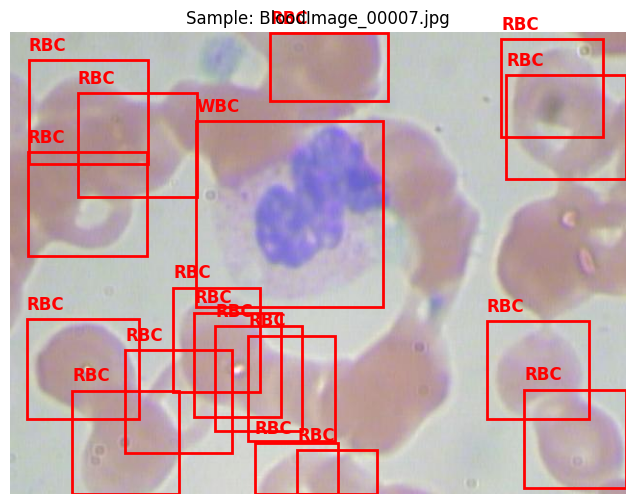

In [3]:
import os
import xmltodict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Paths
img_dir = 'BCCD/JPEGImages'
ann_dir = 'BCCD/Annotations'

# Pick a sample
sample_file = 'BloodImage_00007.jpg'
img_path = os.path.join(img_dir, sample_file)
xml_path = os.path.join(ann_dir, sample_file.replace('.jpg', '.xml'))

# Load image
image = Image.open(img_path)

# Load annotation
with open(xml_path) as f:
    ann = xmltodict.parse(f.read())

objects = ann['annotation']['object']
if not isinstance(objects, list):
    objects = [objects]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(image)
for obj in objects:
    label = obj['name']
    bbox = obj['bndbox']
    x, y = int(bbox['xmin']), int(bbox['ymin'])
    w = int(bbox['xmax']) - x
    h = int(bbox['ymax']) - y
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x, y - 10, label, color='red', fontsize=12, weight='bold')

plt.axis('off')
plt.title(f"Sample: {sample_file}")
plt.show()


In [4]:
import os
import shutil
import random

img_dir = 'BCCD/JPEGImages'
ann_dir = 'BCCD/Annotations'

output_base = 'BCCD_split'
os.makedirs(output_base, exist_ok=True)

splits = ['train', 'val', 'test']
split_ratio = [0.7,0.2,0.1] #70/20/10 split ratio diversity

all_images = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
random.shuffle(all_images)

n_total = len(all_images)
split_counts = [int(n_total*ratio) for ratio in split_ratio]
split_counts[-1] = n_total - sum(split_counts[:-1]) #adjust remainder

split_files= {
    'train' : all_images[:split_counts[0]],
    'val' : all_images[split_counts[0]:split_counts[0]+split_counts[1]],
    'test' : all_images[split_counts[0]+split_counts[1]:]

}

for split in splits:
  for sub in ['images', 'annotations']:
    os.makedirs(os.path.join(output_base, split, sub), exist_ok=True)
  for file in split_files[split]:
    xml_file = file.replace('.jpg', '.xml')

    shutil.copy(os.path.join(img_dir, file), os.path.join(output_base, split, 'images', file))
    shutil.copy(os.path.join(ann_dir, xml_file), os.path.join(output_base, split, 'annotations', xml_file))

In [5]:
from PIL import Image
import xmltodict

def crop_cells(image_path, xml_path, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    image = Image.open(image_path)
    with open(xml_path) as f:
        ann = xmltodict.parse(f.read())
    objects = ann['annotation']['object']
    if not isinstance(objects, list):
        objects = [objects]
    for idx, obj in enumerate(objects):
        bbox = obj['bndbox']
        label = obj['name']
        xmin = int(bbox['xmin'])
        ymin = int(bbox['ymin'])
        xmax = int(bbox['xmax'])
        ymax = int(bbox['ymax'])

        # Check if bounding box dimensions are valid
        if xmax > xmin and ymax > ymin:
            crop = image.crop((xmin, ymin, xmax, ymax))
            class_dir = os.path.join(out_dir, label)
            os.makedirs(class_dir, exist_ok=True)
            crop.save(os.path.join(class_dir, f"{os.path.basename(image_path)[:-4]}_{idx}.jpg"))
        else:
            print(f"Skipping invalid bounding box in {xml_path} for object {idx}: xmin={xmin}, ymin={ymin}, xmax={xmax}, ymax={ymax}")


# Run this on all training images
input_images = os.listdir(os.path.join(output_base, 'train', 'images'))
for file in input_images:
    img_path = os.path.join(output_base, 'train', 'images', file)
    xml_path = os.path.join(output_base, 'train', 'annotations', file.replace('.jpg', '.xml'))
    crop_cells(img_path, xml_path, 'BCCD_crops')

Skipping invalid bounding box in BCCD_split/train/annotations/BloodImage_00338.xml for object 12: xmin=504, ymin=337, xmax=504, ymax=337


In [6]:
def voc_to_yolo(xml_path, img_width, img_height, class_map):
  with open(xml_path) as f:
    ann = xmltodict.parse(f.read())

  objects = ann['annotation']['object']
  if not isinstance(objects, list):
    objects = [objects]

  yolo_labels = []
  for obj in objects:
    label = obj['name']
    bbox = obj['bndbox']
    xmin = int(bbox['xmin'])
    ymin = int(bbox['ymin'])
    xmax = int(bbox['xmax'])
    ymax = int(bbox['ymax'])

    x_center = (xmin + xmax) / 2 / img_width
    y_center = (ymin + ymax) / 2 / img_height
    width = (xmax - xmin) / img_width
    height = (ymax - ymin) / img_height

    class_id = class_map[label]
    yolo_labels.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    return yolo_labels

class_map = {'WBC':0, 'RBC':1, 'Platelets':2}
yolo_out = 'BCCD_yolo_labels'
os.makedirs(yolo_out, exist_ok=True)

for file in os.listdir(os.path.join(output_base, 'train', 'images')):
   img_path = os.path.join(output_base, 'train', 'images', file)
   xml_path = os.path.join(output_base, 'train', 'annotations', file.replace('.jpg', '.xml'))
   image = Image.open(img_path)

   yolo_labels = voc_to_yolo(xml_path, image.width, image.height, class_map)
   with open(os.path.join(yolo_out, file.replace('.jpg', '.txt')), 'w') as f:
    f.write('\n'.join(yolo_labels))

In [7]:
import csv

count_csv = 'cell_counts.csv'
with open(count_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['image', 'WBC', 'RBC', 'Platelets'])

    for file in os.listdir(os.path.join(output_base, 'train', 'annotations')):
        xml_path = os.path.join(output_base, 'train', 'annotations', file)
        with open(xml_path) as f:
            ann = xmltodict.parse(f.read())
        objects = ann['annotation']['object']
        if not isinstance(objects, list):
            objects = [objects]
        count = {'WBC': 0, 'RBC': 0, 'Platelets': 0}
        for obj in objects:
            label = obj['name']
            count[label] += 1
        writer.writerow([file.replace('.xml', '.jpg'), count['WBC'], count['RBC'], count['Platelets']])


In [8]:
import numpy as np
from PIL import ImageDraw

mask_out = 'BCCD_masks'
os.makedirs(mask_out, exist_ok=True)

for file in os.listdir(os.path.join(output_base, 'train', 'annotations')):
    xml_path = os.path.join(output_base, 'train', 'annotations', file)
    img_path = os.path.join(output_base, 'train', 'images', file.replace('.xml', '.jpg'))

    image = Image.open(img_path)
    mask = Image.new('L', image.size, 0)
    draw = ImageDraw.Draw(mask)

    with open(xml_path) as f:
        ann = xmltodict.parse(f.read())

    objects = ann['annotation']['object']
    if not isinstance(objects, list):
        objects = [objects]

    for obj in objects:
        bbox = obj['bndbox']
        draw.rectangle([int(bbox['xmin']), int(bbox['ymin']), int(bbox['xmax']), int(bbox['ymax'])], fill=255)

    mask.save(os.path.join(mask_out, file.replace('.xml', '.png')))
